In [1]:
#mengimpor library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
##### HANDLING WARNING ##############
##C:\Users\Proyecto\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster_kmeans.py:1429:
#UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there
#are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

import os
# Set the environment variable
os.environ['OMP_NUM_THREADS' ] = '1'
#### HANDLING BUG in threadpoolctl####
#!pip install -- upgrade scikit-learn numpy threadpoolctl

In [2]:
path = "..\Dataset\API_Kaggle\penguins.csv"
df = pd.read_csv(path)
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [3]:
#Data Preprocessing
#mengubah nama kolom
new_names={'culmen_length_mm': 'culmen_length','culmen_depth_mm' :'culmen_depth',
'flipper_length_mm' : 'flipper_length', 'body_mass_g' : 'body_mass'}
df.rename(columns=new_names, inplace=True)
#perintah inplace = True akan menyimpan perubahan yang dilakukan
#sehingga jika ditampilkan, dataframe tetap akan menyimpan perubahan tersebut
df

,culmen_length,culmen_depth,flipper_length,body_mass,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [4]:
df.isna().sum()

culmen_length     2
culmen_depth      2
flipper_length    2
body_mass         2
sex               9
dtype: int64

In [5]:
#melakukan imputasi dengan nilai Mean
#untuk kolom culmen_length, culmen_depth, flipper_length, body_mass
df["culmen_length"] = df["culmen_length"].fillna(value=df["culmen_length"].mean())
df["culmen_depth"] = df["culmen_depth"].fillna(value=df["culmen_depth"].mean())
df["flipper_length"] = df["flipper_length"].fillna(value=df["flipper_length"].mean())
df["body_mass"] = df["body_mass"].fillna(value=df["body_mass"].mean())
df.isna().sum()

culmen_length     0
culmen_depth      0
flipper_length    0
body_mass         0
sex               9
dtype: int64

In [6]:
#melakukan imputasi dengan nilai Modus untuk kolom sex
modus = df['sex'].mode() [0]
df['sex' ] = df['sex'].fillna(modus)
df.isna().sum()

culmen_length     0
culmen_depth      0
flipper_length    0
body_mass         0
sex               0
dtype: int64

In [7]:
le = LabelEncoder()
feature = ['sex']
df[feature] = df[feature].apply(le.fit_transform)
df

,culmen_length,culmen_depth,flipper_length,body_mass,sex
0,39.10000,18.70000,181.00000,3750.000000,2
1,39.50000,17.40000,186.00000,3800.000000,1
2,40.30000,18.00000,195.00000,3250.000000,1
3,43.92193,17.15117,214.01462,4201.754386,2
4,36.70000,19.30000,193.00000,3450.000000,1
...,...,...,...,...,...
339,43.92193,17.15117,214.01462,4201.754386,2
340,46.80000,14.30000,215.00000,4850.000000,1
341,50.40000,15.70000,222.00000,5750.000000,2
342,45.20000,14.80000,212.00000,5200.000000,1


In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
X   

array([[0.25454545, 0.66666667, 0.06098987, 0.29166667, 1.        ],
       [0.26909091, 0.51190476, 0.06196415, 0.30555556, 0.5       ],
       [0.29818182, 0.58333333, 0.06371785, 0.15277778, 0.5       ],
       ...,
       [0.66545455, 0.30952381, 0.06897896, 0.84722222, 1.        ],
       [0.47636364, 0.20238095, 0.0670304 , 0.69444444, 0.5       ],
       [0.64727273, 0.35714286, 0.06722525, 0.75      , 1.        ]])

In [9]:
#Data Clustering and Evaluation
#Membangun model klustering dengan beberapa pilihan nilai parameter
#Menguji dengan metrik Davies Bouldin Score,
#Silhouette Score dan Calinski-Harabasz Index

clusters, db, slc,chs = {}, {}, {}, {}

for i in range(5,10):
    dbscan_model = DBSCAN(eps=0.5, min_samples=i, metric='euclidean',
    metric_params=None, algorithm='auto',
    leaf_size=30, p=None, n_jobs=None).fit(X)
    y_dbscan = dbscan_model. labels_
    clusters[i]= len(np.unique(y_dbscan))
    db[i] = davies_bouldin_score(X,y_dbscan)
    slc[i] = silhouette_score(X,y_dbscan)
    chs[i] = calinski_harabasz_score(X,y_dbscan)
    print("Number cluster = {}".format(clusters[i]))
    print("Davies Bouldin Score = {}".format(db[i]))
    print("Silhouette Score = {}".format(slc[i]))
    print("Calinski-Harabasz Index = {}".format(chs[i]))

Number cluster = 3
Davies Bouldin Score = 1.8347454390684164
Silhouette Score = 0.39475525458235156
Calinski-Harabasz Index = 111.64814035547495
Number cluster = 3
Davies Bouldin Score = 1.8347454390684164
Silhouette Score = 0.39475525458235156
Calinski-Harabasz Index = 111.64814035547495
Number cluster = 3
Davies Bouldin Score = 1.8347454390684164
Silhouette Score = 0.39475525458235156
Calinski-Harabasz Index = 111.64814035547495
Number cluster = 3
Davies Bouldin Score = 1.8347454390684164
Silhouette Score = 0.39475525458235156
Calinski-Harabasz Index = 111.64814035547495
Number cluster = 3
Davies Bouldin Score = 1.8347454390684164
Silhouette Score = 0.39475525458235156
Calinski-Harabasz Index = 111.64814035547495


In [12]:
#Data Clustering and Evaluation
#Membangun model klustering dengan beberapa pilihan nilai parameter
#Menguji dengan metrik Davies Bouldin Score,
#Silhouette Score dan Calinski-Harabasz Index

clusters, db, slc,chs = {}, {}, {}, {}

for i in range(5,10):
    dbscan_model = DBSCAN(eps=0.6, min_samples=i, metric='euclidean',
    metric_params=None, algorithm='auto',
    leaf_size=30, p=None, n_jobs=None).fit(X)
    y_dbscan = dbscan_model.labels_
    clusters[i]= len(np.unique(y_dbscan))
    db[i] = davies_bouldin_score(X,y_dbscan)
    slc[i] = silhouette_score(X,y_dbscan)
    chs[i] = calinski_harabasz_score(X,y_dbscan)
    print("Number cluster = {}".format(clusters[i]))
    print("Davies Bouldin Score = {}".format(db[i]))
    print("Silhouette Score = {}".format(slc[i]))
    print("Calinski-Harabasz Index = {}".format(chs[i]))

Number cluster = 2
Davies Bouldin Score = 0.4311862982614574
Silhouette Score = 0.46489109611544627
Calinski-Harabasz Index = 5.146889159810435
Number cluster = 2
Davies Bouldin Score = 0.4311862982614574
Silhouette Score = 0.46489109611544627
Calinski-Harabasz Index = 5.146889159810435
Number cluster = 2
Davies Bouldin Score = 0.4311862982614574
Silhouette Score = 0.46489109611544627
Calinski-Harabasz Index = 5.146889159810435
Number cluster = 2
Davies Bouldin Score = 0.4311862982614574
Silhouette Score = 0.46489109611544627
Calinski-Harabasz Index = 5.146889159810435
Number cluster = 2
Davies Bouldin Score = 0.4311862982614574
Silhouette Score = 0.46489109611544627
Calinski-Harabasz Index = 5.146889159810435


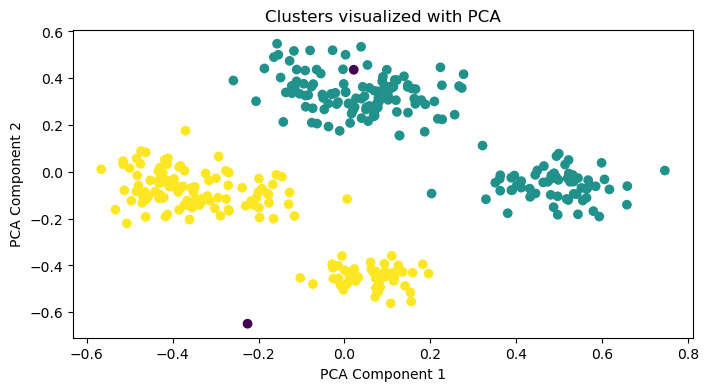

In [13]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster terbaik
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
dbscan_model = DBSCAN(eps=0.5, min_samples=5, metric='euclidean',
metric_params=None, algorithm='auto',
leaf_size=30, p=None, n_jobs=None).fit(X)
y_dbscan = dbscan_model.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_dbscan, cmap='viridis')
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

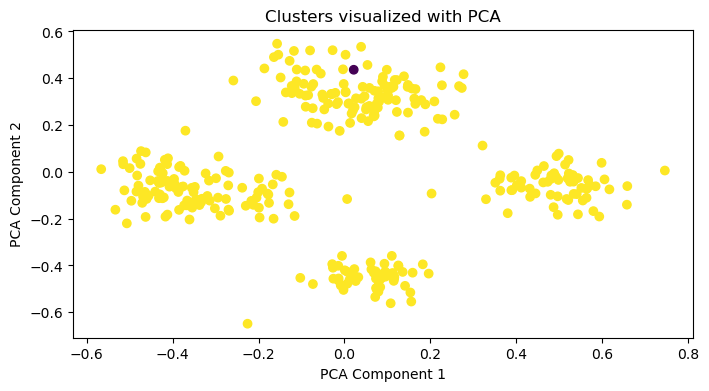

In [14]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster terbaik
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
dbscan_model = DBSCAN(eps=0.6, min_samples=5, metric='euclidean',
metric_params=None, algorithm='auto',
leaf_size=30, p=None, n_jobs=None).fit(X)
y_dbscan = dbscan_model.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_dbscan, cmap='viridis' )
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [15]:
#DATASET 2

In [27]:
#Data Collection and Transformation
# membuat dataset circle dan menormalisasi data
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

X, y = make_circles(n_samples=750, factor=0.3, noise=0.1)
X = StandardScaler().fit_transform(X)
X

array([[-1.05398889,  1.29779063],
       [ 0.82158632,  1.48815884],
       [ 0.28484912,  0.84073837],
       ...,
       [ 0.2170102 ,  0.55329356],
       [-1.03601436, -1.16439016],
       [ 1.22170356, -1.15923573]])

In [28]:
#Data Clustering
#Membangun model klustering dengan beberapa pilihan nilai parameter

dbscan_model = DBSCAN(eps=0.3, min_samples=10, metric='euclidean',
metric_params=None, algorithm='auto',
leaf_size=30, p=None, n_jobs=None).fit(X)
y_dbscan = dbscan_model.labels_
print(y_dbscan)

[ 0  0  1  1  0  0  0  1  1  1  0  1  0  0  0  0  1  1  1  1  1  1  1  1
  1  1  0  1  0  1  0  1  0  1  0  0  0  0  1  1  1  0  0  0  1  0  0  0
  0  0  1  0  1  1  1  0  1  0  0  0  1  1  0  1  1  0  0 -1  1  1  1  0
  0  0  0  1  1  1  0  0  0  1  1  0  0  0  1  0  0  1  0  0  0  0  1  0
  1  0  0  0  1  0  0  0  1  0  1  1  0  1  1  1  1  1  1  1  0  0  0  1
  1  0  1  1  0  1  1  1  0  0  1  0  1  1  1  1  0  0  0  1  0  0  1  1
  1  1  0  1 -1  0  0  1  0  0  1  1  0  1  1  1  1  1  0  1  1  1  1  0
  1  0  0  1  0  0  1  1  1  0  0  1  0  1  0  1  0  0  1  0  0  0 -1  1
  0  1  1  1  0  0  1  0  0  1  0  1  0  1  1  0  0  0  0  1  0  0  1  1
  0  1  0  1  0  0  1  0  0  1  0  1  0  1  0  0  1  1  0  0  1  0  1  1
  0  1  0  1  1  1  1  1  1  1  0  0  1  0  1  0  0  1  0  0  1  1  1  1
  1  1  0  0  1  0  1  1  1  1  1  0  1  0  1  0  1  0  1  0  0  0  0  0
  1  1  1  1  0  0  0  0  0  0  1  0  1  0  0  1  0  0  1  1  0  1  1  0
  1  0  0  0  0  1  1  0  1  0  0  0  1  1  1  0  0

In [29]:
#Model Evaluation
#Menguji dengan metrik Davies Bouldin Score,
#Silhouette Score dan Calinski-Harabasz Index
#Homogeneity, Completeness, V-measure
#Adjusted Rand Index, Adjusted Mutual Information

from sklearn import metrics


clusters = len(np.unique(y_dbscan))
db = davies_bouldin_score(X,y_dbscan)
slc = silhouette_score(X,y_dbscan)
chs = calinski_harabasz_score(X,y_dbscan)
hg = metrics.homogeneity_score(y, y_dbscan)
cm = metrics.completeness_score(y, y_dbscan)
vm = metrics.v_measure_score(y, y_dbscan)
ari = metrics.adjusted_rand_score(y, y_dbscan)
ami = metrics.adjusted_mutual_info_score(y, y_dbscan)
print("Number cluster = {}".format(clusters))
print("Davies Bouldin Score = {}".format(db))
print("Silhouette Score = {}".format(slc))
print("Calinski-Harabasz Index = {}".format(chs))
print("Homogeneity = {}".format(hg))
print("Completeness = {}".format(cm))
print("V-measure = {}".format(vm))
print("Adjusted Rand Index = {}".format(ari))
print("Adjusted Mutual Information = {}".format(ami))

Number cluster = 3
Davies Bouldin Score = 55.04775987970836
Silhouette Score = 0.19351498362527098
Calinski-Harabasz Index = 0.5636536249837866
Homogeneity = 1.0
Completeness = 0.924494011741168
V-measure = 0.9607657972442748
Adjusted Rand Index = 0.9765439499538553
Adjusted Mutual Information = 0.9606905553231029


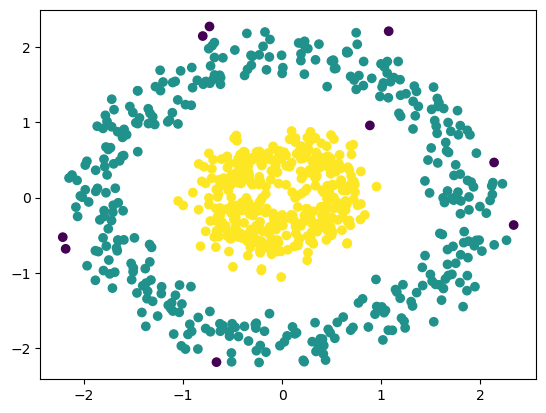

In [30]:
plt.scatter(X[:, 0], X[:, 1], c=y_dbscan)